In [1]:
using Random, JuMP, Clp, LinearAlgebra, SparseArrays, DifferentialEquations, Plots, Sundials, LaTeXStrings 
Random.seed!(1)

n = 5
m = 2
c = 2.0*rand(n)
A = 2.0*rand(m,n) .- 1.0
b = 2.0*rand(m) .- 1.0
# To make the LP infeasible, we add the contradictory constraint: sum(x)<=-1
A = [A; -ones(1,n)]
b = [b; 1.0]
m = m + 1
# using CLP to solve the LP: min x' * c, s.t. Ax>=b, x>=0
Prob = Model(Clp.Optimizer)
@variable(Prob, x[1:n]>=0)
@objective(Prob, Min, c'*x)
@constraint(Prob, A*x .>= b)
optimize!(Prob)
status = termination_status(Prob)
println("Solver status: ", status)

Solver status: INFEASIBLE
Coin0507I Presolve determined that the problem was infeasible with tolerance of 1e-08
Clp3003W Analysis indicates model infeasible or unbounded
Clp0006I 0  Obj 0 Primal inf 2.7131517 (3)
Clp0006I 2  Obj 4.6339915 Primal inf 2.6417123 (1)
Clp0001I Primal infeasible - objective value 4.6339915
Clp0032I PrimalInfeasible objective 4.633991543 - 2 iterations time 0.002


In [2]:
function Homogeneous_massfun(z,c,A,b,n,m)
    x = z[1:n]
    y = z[n+1:n+m]
    tau = z[n+m+1]
    s = z[n+m+1+1:n+m+1+n]
    v = z[n+m+1+n+1:n+m+1+n+m]
    kappa = z[n+m+1+n+m+1]
    nabla_psi = [zeros(n,n) -A' c;
                 A zeros(m,m) -b;
                 -c' b' 0]
    M = [nabla_psi -Diagonal(ones(n+m+1));
         Diagonal([s;v;kappa]) Diagonal([x;y;tau])]
    return M
end

function Homogeneous_odefun(z,c,A,b,n,m,k)
    x = z[1:n]
    y = z[n+1:n+m]
    tau = z[n+m+1]
    s = z[n+m+1+1:n+m+1+n]
    v = z[n+m+1+n+1:n+m+1+n+m]
    kappa = z[n+m+1+n+m+1]
    temp = [-A'*y+tau*c-s;
            A*x-tau*b-v;
            -x'*c+y'*b-kappa;
            x.*s;
            y.*v;
            tau*kappa]
    dzdt = -k*(1/norm(temp)+norm(temp))*temp
    return dzdt
end

function Homogeneous_ode!(residual, dz, z, p, t)
    c, A, b, n, m, k = p
    residual .= Homogeneous_massfun(z,c,A,b,n,m) * dz - Homogeneous_odefun(z,c,A,b,n,m,k)
end

Homogeneous_ode! (generic function with 1 method)

In [3]:
Tp = 1.0
k = 2*pi/(4.0*Tp)
Tmax = 0.999*Tp
p = (c,A,b,n,m,k)
z0 = 5*ones(2*(n+m+1))
dz0 = zeros(2*(n+m+1))
tspan = (0.0, Tmax)
differential_vars = [true for _ in 1:2*(n+m+1)]
Homogeneous_prob = DAEProblem(Homogeneous_ode!, dz0, z0, tspan, p, differential_vars = differential_vars)
t_points = range(tspan[1],tspan[2],length=10000)
# sol = solve(Homogeneous_prob,abstol=1e-8,reltol=1e-8,saveat=t_points;alg_hints=[:stiff])
sol = solve(Homogeneous_prob,DFBDF(),saveat=t_points)
tau_equi = sol[n+m+1,end]
kappa_equi = sol[n+m+1+n+m+1,end]
if tau_equi<kappa_equi
    println("The problem is infeasible")
else
    println("tau is", tau_equi, "kappa is", kappa_equi)
end

The problem is infeasible


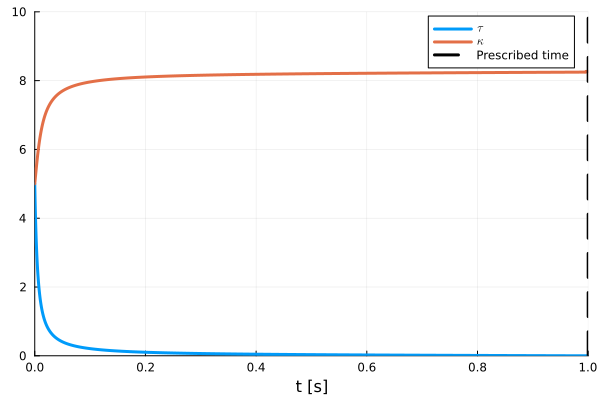

In [4]:
tau_traj = sol[n+m+1,:]
kappa_traj = sol[n+m+1+n+m+1,:]
plot(sol.t,tau_traj,linewidth=3,xlabel="t [s]",label=L"$\tau$")
plot!(sol.t,kappa_traj,linewidth=3,label=L"$\kappa$")
vline!([Tp], linestyle=:dash, color=:black,linewidth=3, label="Prescribed time")
xlims!(0, 1)
ylims!(0, 10)
plot!(legend=(0.8,0.95))

In [5]:
savefig("Fig7_LP_Infeasible.pdf")

"/Users/liang/Documents/Julia/AnalogOpti_Code_v1/Fig7_LP_Infeasible.pdf"

In [ ]:
num_cases = 100
counter = 0
for i=1:num_cases
    n = 5
    m = 2
    c = 2.0*rand(n)
    A = 2.0*rand(m,n) .- 1.0
    b = 2.0*rand(m) .- 1.0
    # To make the LP infeasible, we add the contradictory constraint: sum(x)<=-1
    A = [A; -ones(1,n)]
    b = [b; 1.0]
    m = m + 1   
    # check whether the fixed-time-stable ODE method successfully detecting the infeasibility
    Tp = 1.0
    k = 2*pi/(4.0*Tp)
    Tmax = 0.99*Tp
    p = (c,A,b,n,m,k)
    z0 = 5*ones(2*(n+m+1))
    dz0 = zeros(2*(n+m+1))
    tspan = (0.0, Tmax)
    differential_vars = [true for _ in 1:2*(n+m+1)]
    Homogeneous_prob = DAEProblem(Homogeneous_ode!, dz0, z0, tspan, p, differential_vars = differential_vars)
    t_points = range(tspan[1],tspan[2],length=10000)
    sol = solve(Homogeneous_prob,DFBDF(),saveat=t_points)
    tau_equi = sol[n+m+1,end]
    kappa_equi = sol[n+m+1+n+m+1,end]
    if tau_equi<kappa_equi
        counter = counter + 1 
    end
end
rate = counter/num_cases
println("The rate of infeasibility detecting is ", rate)

The rate of infeasibility detecting is 1.0
